# Three Body Problem: Neural Network Training

A simple neural network is trained to learn approximate solutions to the three body problem.<br>
Data is sampled from three body systems with parameters similar to planets in the solar system.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style, range_inc
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from jacobi import CartesianToJacobi, JacobiToCartesian

from g3b_data import make_traj_g3b, make_data_g3b, make_datasets_g3b, traj_to_batch
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_data import combine_datasets_g3b, combine_datasets_solar
from sej_data import load_data_sej, make_datasets_sej, combine_datasets_sej

from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import fit_model
from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn

In [3]:
# Set active GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1:2], 'GPU')

In [4]:
# Grow GPU memory (must be first operation in TF)
# gpu_grow_memory()

In [5]:
# Lightweight serialization
fname = '../data/g3b/g3b_train.pickle'
vartbl = load_vartbl(fname)

In [6]:
# Set plot style
plot_style()

### Load Data for General Three Body Problem

In [7]:
# Description of datasets to be loaded
n_years = 100
sample_freq = 10
traj_size = n_years * sample_freq + 1

In [8]:
# Configuration for loading data sets
# num_data_sets = 50
num_data_sets = 5
batch_size = 256
# num_gpus = 1
# full_batch_size = num_gpus * batch_size

# Set size of tiny data sets
n_traj_tiny = batch_size

# Set starting random seed
seed0 = 42

In [9]:
# Create a tiny data set with one batch of solar type orbits
ds_tiny_solar, _ , _ = \
    make_datasets_solar(n_traj=n_traj_tiny, vt_split=0.0, 
                        n_years=n_years, sample_freq=sample_freq,
                        batch_size=batch_size, seed=seed0)

Loaded data from ../data/g3b/1789961721.pickle.


W0821 11:35:31.928282 139780329862976 deprecation.py:323] From /home/michael/anaconda3/envs/nbody/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# Build combined solar data sets
# ds_solar_trn, ds_solar_val, ds_solar_tst = \
#     combine_datasets_solar(num_data_sets=num_data_sets, batch_size=batch_size, seed0=seed0)

### Load Data for Perturbed Sun-Earth-Jupiter System

In [11]:
# Orbital perturbation scales
sd_log_a = 0.01
sd_log_e = 0.10
sd_log_inc = 0.10
sd_Omega = np.pi * 0.02
sd_omega = np.pi * 0.02
sd_f = np.pi * 0.02

# Wrap into dictionary
sej_sigma = {
    'sd_log_a': sd_log_a,
    'sd_log_e': sd_log_e,
    'sd_log_inc': sd_log_inc,
    'sd_Omega': sd_Omega,
    'sd_omega': sd_omega,
    'sd_f': sd_f
}

In [12]:
# Create a tiny data set with one batch of perturbed SEJ orbits
ds_tiny_sej, _ , _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      **sej_sigma,
                      batch_size=batch_size, seed=seed0)

Loaded data from ../data/sej/1026452775.pickle.


In [13]:
# Create dictionary for sigmas of unperturbed orbits: all sd are zero (always same elements)
sej_sigma0 = {k: v*0.0 for k, v in sej_sigma.items()}

# Create a tiny data set with the unperturbed SEJ system
ds_sej0, _, _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      **sej_sigma0,
                      batch_size=batch_size, seed=0)

Loaded data from ../data/sej/3203691191.pickle.


In [14]:
# Build combined SEJ data sets
ds_sej_trn, ds_sej_val, ds_sej_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, seed0=seed0)

Loaded data from ../data/sej/4087833051.pickle.


Loaded data from ../data/sej/3169253148.pickle.
Loaded data from ../data/sej/155748689.pickle.
Loaded data from ../data/sej/3645397039.pickle.
Loaded data from ../data/sej/2755636330.pickle.



***Choose Data Set for Analysis: Solar vs. SEJ***

In [15]:
# Alias ds_trn, ds_val, ds_tst to selected source

# The selected data type for this analysis
data_type = 'SEJ'

# Tables mapping data type to tuple of data sets
data_by_type = {
    # 'solar': (ds_tiny_solar, ds_solar_trn, ds_solar_val, ds_solar_tst),
    'SEJ': (ds_tiny_sej, ds_sej_trn, ds_sej_val, ds_sej_tst)
}

# Perform the aliasing
ds_tiny, ds_trn, ds_val, ds_tst = data_by_type[data_type]

### Create the Kepler-Jacobi Model as a Benchmark

In [16]:
model_kj = make_model_g3b_math(traj_size=traj_size, batch_size=batch_size)

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.0)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0E-6),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0E4,
                'v0_rec': 1.0E4,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [18]:
# Compile the full mathematical model
model_kj.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [19]:
# Evaluate KJ model on unperturbed SEJ data set
model_kj.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.6520e-05 - q_loss: 1.9148e-05 - v_loss: 1.9136e-05 - a_loss: 2.8235e-05 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 2.2975e-13 - P_loss: 4.1866e-14 - L_loss: 7.2123e-14


[6.651984585914761e-05,
 1.9148267e-05,
 1.9135909e-05,
 2.8235167e-05,
 4.116526e-14,
 9.423976e-15,
 2.2974615e-13,
 4.1866443e-14,
 7.2123155e-14]

In [20]:
# Evaluate KJ model on tiny data set
model_kj.evaluate(ds_tiny)

1/1 [==============================] - 0s 115ms/step - loss: 6.4279e-05 - q_loss: 1.8427e-05 - v_loss: 1.8415e-05 - a_loss: 2.7436e-05 - q0_rec_loss: 1.4879e-14 - v0_rec_loss: 1.3018e-14 - H_loss: 9.3354e-14 - P_loss: 3.8772e-14 - L_loss: 2.0240e-14


[6.427881453419104e-05,
 1.8427074e-05,
 1.8414992e-05,
 2.7436467e-05,
 1.4878642e-14,
 1.3017593e-14,
 9.33544e-14,
 3.877194e-14,
 2.0240327e-14]

In [21]:
# Evaluate KJ model on full validation data
model_kj.evaluate(ds_val)

35/35 [==============================] - 4s 115ms/step - loss: 6.5870e-05 - q_loss: 1.8911e-05 - v_loss: 1.8899e-05 - a_loss: 2.8060e-05 - q0_rec_loss: 1.4463e-14 - v0_rec_loss: 1.2528e-14 - H_loss: 9.3760e-14 - P_loss: 3.8766e-14 - L_loss: 1.9768e-14


[6.587040261365473e-05,
 1.8911158e-05,
 1.8898823e-05,
 2.806015e-05,
 1.4462772e-14,
 1.2528137e-14,
 9.376004e-14,
 3.876589e-14,
 1.9768472e-14]

### Train the Neural Network Model

In [61]:
# Configuration for neural network model architecture
# hidden_sizes = [64, 16]
hidden_sizes = []
skip_layers = True
traj_size = 1001

# Training configuration
# reg = 1.0E2
reg = 0.0
kernel_reg = reg
activity_reg = reg
learning_rate = 1.0E-6

In [62]:
# Build neural network model
model_nn = make_model_g3b_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers, 
                             kernel_reg=kernel_reg, activity_reg=activity_reg,
                             traj_size=traj_size, batch_size=batch_size)

In [63]:
# model_nn.summary()

In [64]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adadelta()

In [65]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [66]:
# Evaluate the NN model on the unperturbed orbit
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.6520e-05 - q_loss: 1.9148e-05 - v_loss: 1.9136e-05 - a_loss: 2.8235e-05 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 2.2975e-13 - P_loss: 4.1866e-14 - L_loss: 7.2123e-14


[6.651984585914761e-05,
 1.9148267e-05,
 1.9135909e-05,
 2.8235167e-05,
 4.116526e-14,
 9.423976e-15,
 2.2974615e-13,
 4.1866443e-14,
 7.2123155e-14]

In [67]:
# Evaluate the NN model on the tiny data set
# model_nn.evaluate(ds_tiny)

In [68]:
# Evaluate the NN model on the full validation data
# model_nn.evaluate(ds_val)

In [69]:
# Compare this to math model - should be the same before training
# model_math.evaluate(ds_val)

# Hard coded baseline losses
loss_baseline_list = \
[6.427881453419104e-05,
 1.8427074e-05,
 1.8414992e-05,
 2.7436467e-05,
 1.4878642e-14,
 1.3017593e-14,
 9.33544e-14,
 3.877194e-14,
 2.0240327e-14]

# Baseline position loss
q_loss_baseline = loss_baseline_list[1]

# Table of baseline losses
keys = ['loss', 'q_loss', 'v_loss', 'a_loss', 'q0_rec_loss', 'v0_rec_loss', 'H_loss', 'P_loss', 'L_loss']
loss_baseline = {key: loss_baseline_list[i] for i, key in enumerate(keys)}
# Set dummy batch_num and time
loss_baseline['batch_num'] = 0
loss_baseline['time'] = 0.0

# Initialize history before training
hist0 = {key: np.array([val], dtype=np.float32) for key, val in loss_baseline.items()}

# Review baseline loss table
# loss_baseline

In [70]:
# Set up training
suffix = '_'.join(str(sz) for sz in hidden_sizes)
if data_type == 'solar':
    model_name = f'model_g3b_nn_{suffix}'
    folder = 'g3b'
elif data_type == 'SEJ':
    model_name = f'model_sej_nn_{suffix}'
    folder = 'sej'
model_h5 = f'../models/g3b/{model_name}.h5'
hist_name = model_name.replace('model_', 'hist_')
epochs = 1
save_freq = 'epoch'

### Train on Unperturbed Model (ds_sej0)

In [71]:
hist = fit_model(model=model_nn,
                 folder=folder,
                 ds=ds_sej0, 
                 epochs=epochs,
                 save_freq=save_freq,
                 prev_history = hist0, 
                 batch_num=1)


Epoch 0001; loss 6.65e-05; elapsed 0:00:06
1/1 [==============================] - 6s 6s/step - loss: 6.6520e-05 - q_loss: 1.9148e-05 - v_loss: 1.9136e-05 - a_loss: 2.8235e-05 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 2.2975e-13 - P_loss: 4.1866e-14 - L_loss: 7.2123e-14


In [72]:
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 0s 126ms/step - loss: 4.3504e-04 - q_loss: 1.4086e-04 - v_loss: 1.5514e-04 - a_loss: 1.2386e-04 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 8.4000e-07 - P_loss: 3.9661e-14 - L_loss: 1.4339e-05


[0.00043503730557858944,
 0.00014085506,
 0.00015514014,
 0.00012386245,
 4.116526e-14,
 9.423976e-15,
 8.4000203e-07,
 3.9661396e-14,
 1.4339153e-05]

In [74]:
for i in range_inc(1, 5):
    ts = datetime.datetime.now()
    st = ts.strftime('%Y-%m-%d %H:%M:%S')
    print(f'*** Training loop {i:3} *** - {st}')
    hist = fit_model(model=model_nn,
                     folder=folder,
                     ds=ds_sej0, 
                     epochs=10,
                     save_freq=save_freq,
                     prev_history = hist, 
                     batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

*** Training loop   1 *** - 2019-08-21 11:50:20
Epoch 1/10

Epoch 0001; loss 3.54e-05; elapsed 0:00:00
1/1 [==============================] - 0s 210ms/step - loss: 3.5384e-05 - q_loss: 1.1137e-05 - v_loss: 1.1291e-05 - a_loss: 1.2091e-05 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 1.4329e-07 - P_loss: 3.9998e-14 - L_loss: 7.2168e-07
Epoch 2/10

Epoch 0002; loss 5.74e-05; elapsed 0:00:01
1/1 [==============================] - 0s 179ms/step - loss: 5.7445e-05 - q_loss: 2.1709e-05 - v_loss: 2.1499e-05 - a_loss: 1.1437e-05 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 2.5464e-08 - P_loss: 4.1228e-14 - L_loss: 2.7743e-06
Epoch 3/10

Epoch 0003; loss 7.01e-05; elapsed 0:00:01
1/1 [==============================] - 0s 169ms/step - loss: 7.0072e-05 - q_loss: 2.5141e-05 - v_loss: 2.5384e-05 - a_loss: 1.6338e-05 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 6.8336e-09 - P_loss: 4.0816e-14 - L_loss: 3.2007e-06
Epoch 4/10

Epoch 0004; loss 5.15e-05

Epoch 8/10

Epoch 0008; loss 6.95e-06; elapsed 0:00:02
1/1 [==============================] - 0s 160ms/step - loss: 6.9516e-06 - q_loss: 2.1117e-06 - v_loss: 2.0232e-06 - a_loss: 2.5634e-06 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 8.9217e-09 - P_loss: 4.1246e-14 - L_loss: 2.4379e-07
Epoch 9/10

Epoch 0009; loss 4.28e-06; elapsed 0:00:02
1/1 [==============================] - 0s 162ms/step - loss: 4.2804e-06 - q_loss: 8.8466e-07 - v_loss: 8.6377e-07 - a_loss: 2.4457e-06 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 4.8683e-09 - P_loss: 3.6593e-14 - L_loss: 8.0960e-08
Epoch 10/10

Epoch 0010; loss 2.71e-06; elapsed 0:00:02
1/1 [==============================] - 0s 165ms/step - loss: 2.7112e-06 - q_loss: 2.7091e-07 - v_loss: 3.1501e-07 - a_loss: 2.1222e-06 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 7.4653e-10 - P_loss: 4.0498e-14 - L_loss: 1.8246e-09
*** Training loop   4 *** - 2019-08-21 11:50:27
Epoch 1/10

Epoch 0001; loss 3.39e-0

In [75]:
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 0s 112ms/step - loss: 1.7668e-06 - q_loss: 4.4749e-07 - v_loss: 4.7744e-07 - a_loss: 8.1690e-07 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 4.2421e-10 - P_loss: 4.0806e-14 - L_loss: 2.4081e-08


[1.7668359078015783e-06,
 4.4749197e-07,
 4.7743663e-07,
 8.168965e-07,
 4.116526e-14,
 9.423976e-15,
 4.242086e-10,
 4.0806117e-14,
 2.4080657e-08]

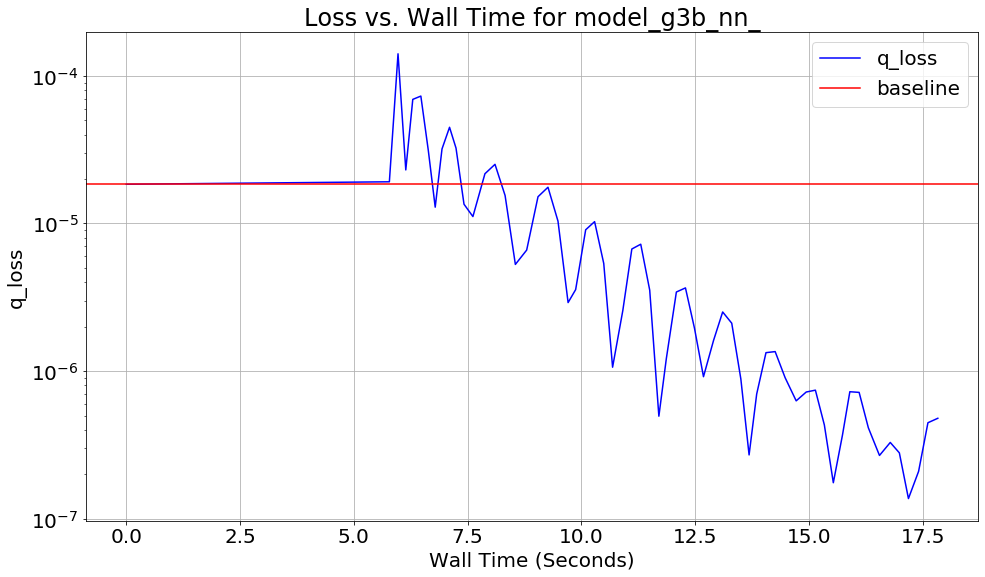

In [78]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

### Train on Tiny Data Set

In [79]:
hist = fit_model(model=model_nn,
                 folder=folder,
                 ds=ds_tiny, 
                 epochs=epochs,
                 save_freq=save_freq,
                 prev_history = hist0, 
                 batch_num=1)


Epoch 0001; loss 5.00e-06; elapsed 0:00:00
1/1 [==============================] - 0s 207ms/step - loss: 4.9985e-06 - q_loss: 1.6102e-06 - v_loss: 1.6379e-06 - a_loss: 1.7256e-06 - q0_rec_loss: 1.4879e-14 - v0_rec_loss: 1.3018e-14 - H_loss: 4.1827e-10 - P_loss: 3.9454e-14 - L_loss: 2.4077e-08


In [80]:
for i in range_inc(1, 5):
    ts = datetime.datetime.now()
    st = ts.strftime('%Y-%m-%d %H:%M:%S')
    print(f'*** Training loop {i:3} *** - {st}')
    hist = fit_model(model=model_nn,
                     folder=folder,
                     ds=ds_sej0, 
                     epochs=10,
                     save_freq=save_freq,
                     prev_history = hist, 
                     batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

*** Training loop   1 *** - 2019-08-21 11:56:04
Epoch 1/10

Epoch 0001; loss 1.16e-06; elapsed 0:00:00
1/1 [==============================] - 0s 214ms/step - loss: 1.1567e-06 - q_loss: 8.2738e-08 - v_loss: 7.2455e-08 - a_loss: 1.0006e-06 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 2.4895e-10 - P_loss: 3.8744e-14 - L_loss: 1.1860e-10
Epoch 2/10

Epoch 0002; loss 1.87e-06; elapsed 0:00:00
1/1 [==============================] - 0s 154ms/step - loss: 1.8720e-06 - q_loss: 1.8962e-07 - v_loss: 2.0604e-07 - a_loss: 1.4584e-06 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 1.8525e-11 - P_loss: 4.0320e-14 - L_loss: 1.7454e-08
Epoch 3/10

Epoch 0003; loss 2.27e-06; elapsed 0:00:01
1/1 [==============================] - 0s 173ms/step - loss: 2.2683e-06 - q_loss: 3.1813e-07 - v_loss: 3.6863e-07 - a_loss: 1.5455e-06 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 1.5040e-10 - P_loss: 3.9861e-14 - L_loss: 3.5344e-08
Epoch 4/10

Epoch 0004; loss 1.70e-06

Epoch 8/10

Epoch 0008; loss 1.25e-06; elapsed 0:00:02
1/1 [==============================] - 0s 159ms/step - loss: 1.2494e-06 - q_loss: 2.6606e-07 - v_loss: 2.6002e-07 - a_loss: 7.1671e-07 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 5.9326e-10 - P_loss: 3.6931e-14 - L_loss: 5.5026e-09
Epoch 9/10

Epoch 0009; loss 1.11e-06; elapsed 0:00:02
1/1 [==============================] - 0s 191ms/step - loss: 1.1124e-06 - q_loss: 1.5019e-07 - v_loss: 1.4239e-07 - a_loss: 8.1900e-07 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 9.0704e-12 - P_loss: 4.1647e-14 - L_loss: 3.0305e-10
Epoch 10/10

Epoch 0010; loss 1.17e-06; elapsed 0:00:02
1/1 [==============================] - 0s 164ms/step - loss: 1.1707e-06 - q_loss: 1.0095e-07 - v_loss: 8.9757e-08 - a_loss: 9.7666e-07 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 7.6801e-10 - P_loss: 4.1036e-14 - L_loss: 2.0496e-09
*** Training loop   4 *** - 2019-08-21 11:56:11
Epoch 1/10

Epoch 0001; loss 1.17e-0

In [81]:
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 0s 117ms/step - loss: 1.0963e-06 - q_loss: 1.0673e-07 - v_loss: 9.6687e-08 - a_loss: 8.9197e-07 - q0_rec_loss: 4.1165e-14 - v0_rec_loss: 9.4240e-15 - H_loss: 1.2328e-10 - P_loss: 3.9700e-14 - L_loss: 3.1688e-10


[1.0963332215396804e-06,
 1.0673262e-07,
 9.668671e-08,
 8.919678e-07,
 4.116526e-14,
 9.423976e-15,
 1.2328481e-10,
 3.9699513e-14,
 3.168825e-10]

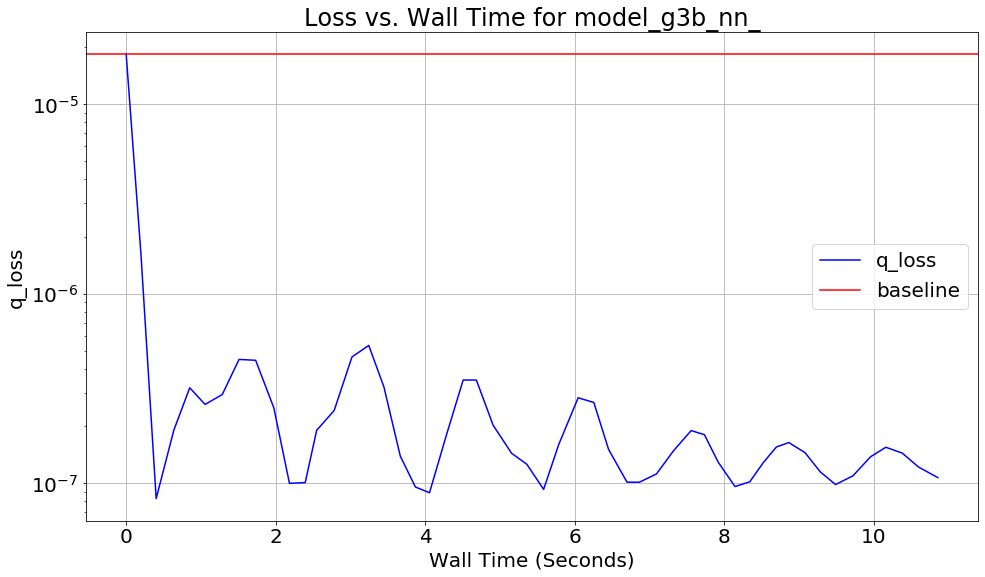

In [82]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set

In [83]:
# Attempt to load model or train a single epoch
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = fit_model(model=model_nn,
                     folder=folder,
                     ds=ds_trn, 
                     epochs=epochs,
                     save_freq=save_freq,
                     prev_history = hist0, 
                     batch_num=1)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_ from ../models/g3b/model_sej_nn_.h5. Fitting...
194/195 [============================>.] - ETA: 0s - loss: 3.3226e-06 - q_loss: 8.4124e-07 - v_loss: 8.3181e-07 - a_loss: 1.6493e-06 - q0_rec_loss: 1.4524e-14 - v0_rec_loss: 1.2677e-14 - H_loss: 3.7784e-12 - P_loss: 3.9296e-14 - L_loss: 1.8879e-11
Epoch 0001; loss 3.32e-06; elapsed 0:00:44
195/195 [==============================] - 36s 184ms/step - loss: 3.3215e-06 - q_loss: 8.4152e-07 - v_loss: 8.3210e-07 - a_loss: 1.6476e-06 - q0_rec_loss: 1.4524e-14 - v0_rec_loss: 1.2677e-14 - H_loss: 3.7597e-12 - P_loss: 3.9297e-14 - L_loss: 1.8784e-11


In [ ]:
num_epochs = 50
for i in range_inc(1, num_epochs):
    ts = datetime.datetime.now()
    st = ts.strftime('%Y-%m-%d %H:%M:%S')
    print(f'*** Training loop {i:3} *** - {st}')
    hist = fit_model(model=model_nn,
                     folder=folder,
                     ds=ds_trn, 
                     epochs=epochs,
                     loss=loss, 
                     optimizer=optimizer,
                     metrics=metrics,
                     save_freq=save_freq,
                     prev_history = hist, 
                     batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

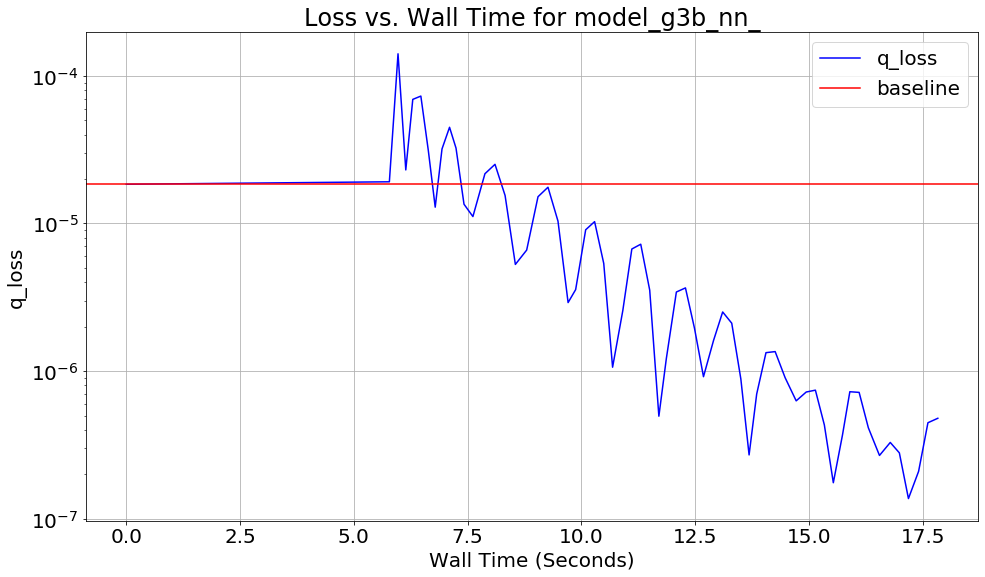

In [77]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

In [ ]:
# Plot the total loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='loss')

In [76]:
hist

{'loss': array([6.42788145e-05, 6.65198459e-05, 4.35037306e-04, 6.69689180e-05,
        1.90699066e-04, 2.33432540e-04, 1.20056109e-04, 4.61401251e-05,
        8.21322756e-05, 1.23659978e-04, 1.02076840e-04, 5.12148254e-05,
        3.53843934e-05, 5.74453952e-05, 7.00716773e-05, 5.15087995e-05,
        2.63664206e-05, 2.47890293e-05, 4.09297063e-05, 4.47498569e-05,
        2.76867650e-05, 1.15569401e-05, 1.52006205e-05, 2.90967655e-05,
        3.04773203e-05, 1.61496755e-05, 4.69722954e-06, 8.93463221e-06,
        1.94339846e-05, 1.98940506e-05, 9.91435900e-06, 2.88709430e-06,
        6.05369905e-06, 1.22280489e-05, 1.19834767e-05, 6.29188435e-06,
        2.81590542e-06, 4.55696681e-06, 7.34154855e-06, 6.95161816e-06,
        4.28043904e-06, 2.71116164e-06, 3.38562381e-06, 4.52962695e-06,
        4.30597311e-06, 2.99786097e-06, 2.22540621e-06, 2.64459732e-06,
        3.17622948e-06, 2.77135882e-06, 1.99813576e-06, 1.94920062e-06,
        2.36552501e-06, 2.23892971e-06, 1.69294697e-06, 

In [ ]:
# Evaluate the trained model on the training data
# model_nn.evaluate(ds_trn)

In [ ]:
# Evaluate the trained model on the test data
# model_nn.evaluate(ds_tst)

## Perturbed Sun-Earth-Jupiter System

In [ ]:
from sej_data import load_data_sej, make_datasets_sej, combine_datasets_sej
import numpy as np
from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
import matplotlib.pyplot as plt

In [ ]:
# Trajectory length
n_years = 100
sample_freq = 10

# Number of trajectories
num_batches = 1
n_traj = 100
vt_split = 0.20
batch_size = 64

In [ ]:
# Orbital perturbation scales
sd_log_a = 0.01
sd_log_e = 0.10
sd_log_inc = 0.10
sd_Omega = np.pi * 0.02
sd_omega = np.pi * 0.02
sd_f = np.pi * 0.02

In [ ]:
# List of seeds to use for datasets
seed0 = 42
seed1 = seed0 + num_batches * 3
seeds = list(range(seed0, seed1, 3))

In [ ]:
data = load_data_sej(n_traj=n_traj, vt_split=vt_split, n_years=n_years, sample_freq=sample_freq,
                     sd_log_a=sd_log_a, sd_log_e=sd_log_e, sd_log_inc=sd_log_inc,
                     sd_Omega=sd_Omega, sd_omega=sd_omega, sd_f=sd_f, seed=seed0)

In [ ]:
inputs_trn, outputs_trn = data[0:2]

data_trn = {**inputs_trn, **outputs_trn}

In [ ]:
inputs_trn['t'].shape

In [ ]:
outputs_trn['q'].shape

In [ ]:
plt.plot(inputs_trn['t'][0], outputs_trn['q'][0][:, 1, 0])

In [ ]:
plt.plot(inputs_trn['t'][0], outputs_trn['q'][0][:, 1, 1])

In [ ]:
np.mean(outputs_trn['orb_a'], axis=(0))

In [ ]:
outputs_trn['orb_a'].shape

In [ ]:
np.mean(outputs_trn['orb_a'][:, 0, :], axis=0)

In [ ]:
np.std(outputs_trn['orb_a'][:, 0, :], axis=0)

In [ ]:
np.mean(outputs_trn['orb_e'][:, 0, :], axis=0)

In [ ]:
np.std(outputs_trn['orb_e'][:, 0, :], axis=0)